In [23]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [24]:
import numpy as np
import pandas as pd

In [25]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [26]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [27]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [28]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [29]:
# Get a list of measurement column names and types
meas_columns = inspector.get_columns('measurement')
for column in meas_columns:
    print(column['name'], column["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [30]:
# Get a list of station column names and types
st_columns = inspector.get_columns('station')
for column in st_columns:
    print(column['name'], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [31]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [32]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [33]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [34]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

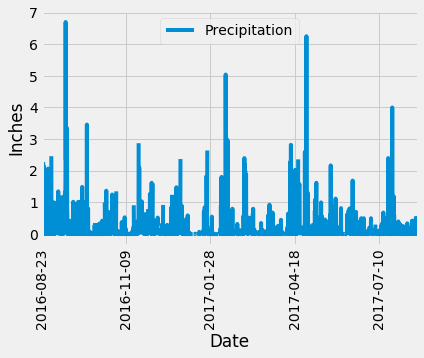

In [53]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Get the date of the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Parse out just the date from the datetime object
last_date = dt.datetime.strptime(last_date[0], "%Y-%m-%d").date()

# Calculate the date 1 year ago from the last data point in the database
year_ago = last_date - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation score
year_prcp = session.query(Measurement.date, Measurement.prcp)\
                .filter(Measurement.date >= year_ago).all()            

# Save the query results as a Pandas DataFrame 
df = pd.DataFrame(year_prcp, columns=['Date', 'Precipitation'])

# Set the index to the date column
df.set_index('Date', inplace=True)

# Sort the dataframe by date
df = df.sort_values(by=['Date'])

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.ylabel("Inches")
plt.xticks(rotation= "vertical")
plt.savefig("precipitation_analysis.png")
plt.show()

In [54]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [57]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement).group_by(Measurement.station).count()
print(f"There are {station_count} stations.")

There are 9 stations.


In [85]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station))\
                    .group_by(Measurement.station)\
                    .order_by(func.count(Measurement.station).desc()).all()

print("Here is the list of stations with the counts in descending order:")
active_stations


Here is the list of stations with the counts in descending order:


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [80]:
most_active_station = active_station[0][0]
station_name = session.query(Station.name).filter_by(station = most_active_station)
station_name = station_name[0][0]

print(f"The most active station is {most_active_station}: {station_name} with {active_station[0][1]} counts.")


The most active station is USC00519281: WAIHEE 837.5, HI US with 2772 counts .


In [86]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

print(f"Lowest Temperature recorded for station id: {most_active_station} is {station_temp[0][0]} Fahrenheit.")
print(f"Highest Temperature recorded for station id: {most_active_station} is {station_temp[0][1]} Fahrenheit.")
print(f"Average Temperature recorded for station id: {most_active_station} is {round(station_temp[0][2], 2)} Fahrenheit.")

Lowest Temperature recorded for station id: USC00519281 is 54.0 Fahrenheit.
Highest Temperature recorded for station id: USC00519281 is 85.0 Fahrenheit.
Average Temperature recorded for station id: USC00519281 is 71.66 Fahrenheit.


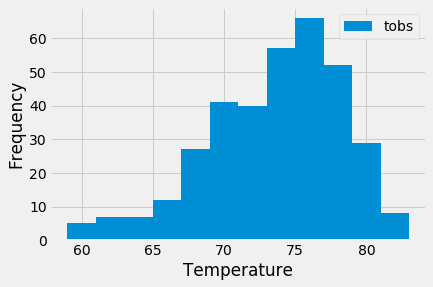

In [97]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = session.query(Measurement.date, Measurement.tobs)\
    .filter(Measurement.station == most_active_station)\
    .filter(Measurement.date > year_ago)\
    .order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame 
temp_df = pd.DataFrame(temp_obs,columns=['Date', 'tobs'])

# Use Pandas Plotting with Matplotlib to plot the data
temp_df.plot.hist(bins=12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.savefig("Temp Obs.png")
plt.show()

## Optional Challenge Assignment

In [103]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [123]:
#save start date and end date
start_date = dt.date(2020, 8, 1)
end_date = dt.date(2020, 8, 12)
print(end_date - start_date)

11 days, 0:00:00


In [124]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-08-01', '2017-08-12')
trip_temps

[(71.0, 78.93478260869566, 83.0)]

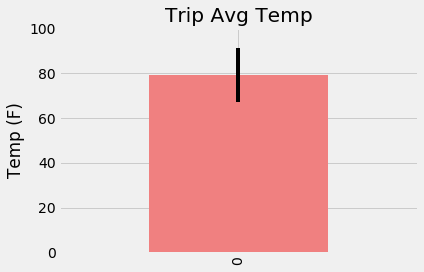

In [125]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
# Save the query results as a Pandas DataFrame 
trip_df = pd.DataFrame(trip_temps,columns=['TMIN', 'TAVE', 'TMAX'])

# Use Pandas Plotting with Matplotlib to plot the data
trip_df.plot.bar(y='TAVE', yerr = (trip_df['TMAX'] - trip_df['TMIN']), title = "Trip Avg Temp", color='lightcoral')
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.ylim(0, 100)
plt.gca().legend_.remove()
plt.show()


In [147]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Find the date after timedelta (3 years )
year_ago_start = start_date - dt.timedelta(days=1095)
year_ago_end = end_date - dt.timedelta(days=1095)






In [148]:
trip_prcp = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.avg(Measurement.prcp))\
                            .filter( Measurement.station == Station.station)\
                            .filter(Measurement.date >= year_ago_start)\
                            .filter(Measurement.date <= year_ago_end)\
                            .group_by(Station.station)\
                            .order_by(func.avg(Measurement.prcp).desc()).all()             
trip_prcp

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.15142857142857144),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.022222222222222223),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.015),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.0016666666666666668),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.0)]

In [149]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
